In [112]:
# -*- coding: utf-8 -*-
import os
import sys
import time
import pandas as pd
import numpy as np
import torch
from torch.optim import Adagrad
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor

sys.path.append("/Users/wzq/Desktop/game")
from deepctr_torch.inputs import get_feature_names
from deepctr_torch.models import *
from deepctr_torch.callbacks import EarlyStopping

from utils import *

# jupyter配置
from IPython.display import display
pd.options.display.max_rows=10000 #Notebook 的一个cell的显示行数
pd.options.display.max_columns=100000#Notebook 的一个cell的显示列数
pd.set_option('display.max_colwidth', None)

## 训练

In [119]:
data = pd.read_csv('./data/data_processed_v8.csv')
print(data.shape)
for f in range(len(data.columns)):
    print(data.columns[f], end=",")
    if f % 20 == 0:
        print()

features = [f for f in data.columns if f not in ["id", "isDefault", "earliesCreditLine", "policyCode", "issueDate"]]

train_size = 800000
target = data.iloc[:train_size, :]['isDefault']
data = data[features]
train_data = data.iloc[:train_size, :]
test_data = data.iloc[train_size:, :]

display(train_data.shape)
display(train_data.head(10))
# display(test_data.shape)
# display(test_data.head(10))
# display(target.shape)
# display(target.head(10))

(1000000, 100)
loanAmnt,
term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,
pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,
n13,n14,issueDate_year,issueDate_month,issueDate_weekday,issueDate_is_weekend,earliesCreditLine_year,earliesCreditLine_month,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,
grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,gra

(800000, 99)

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDate_year,issueDate_month,issueDate_weekday,issueDate_is_weekend,earliesCreditLine_year,earliesCreditLine_month,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14,grade_to_mean_issueDate_year,grade_to_std_issueDate_year,grade_to_mean_issueDate_month,grade_to_std_issueDate_month,grade_to_mean_issueDate_weekday,grade_to_std_issueDate_weekday,grade_to_mean_issueDate_is_weekend,grade_to_std_issueDate_is_weekend,grade_to_mean_earliesCreditLine_year,grade_to_std_earliesCreditLine_year,grade_to_mean_earliesCreditLine_month,grade_to_std_earliesCreditLine_month,grade_target_mean,subGrade_target_mean,homeOwnership_target_mean,verificationStatus_target_mean,purpose_target_mean,postCode_target_mean,regionCode_target_mean,employmentTitle_target_mean,title_target_mean
0,0.873418,1.0,0.553349,0.531301,4,21,305,0.2,2,0.010001,2,1,137,32,0.01805,0.0,0.477273,0.475113,0.077778,0.000000,0.000000,0.008323,0.054802,0.15625,0,0,1,0.000000,0.060606,0.031746,0.031746,0.063492,0.128571,0.060606,0.048193,0.086614,0.044444,0.077778,0.0,0.0,0.0,0.066667,2014,7,1,0,2001,8,0.261962,0.310225,0.484365,0.808250,0.245537,0.622456,0.245537,0.622456,0.739510,0.706262,0.423768,0.555929,0.430800,0.608795,0.293901,0.449355,0.348829,0.452596,0.123717,0.634702,0.291209,0.587947,0.700953,1.0,0.0,0.9559,0.244474,0.663583,0.101450,0.360851,1.000000,0.535197,1.000000,0.659961,0.288196,0.380061,0.0,1.0,0.628293,0.613154,0.000000,0.141303,0.741833,0.667385,0.677699,1.000000,1.000000,0.193253,0.593876,0.165923,0.305068
1,0.443038,1.0,0.513240,0.263246,3,16,176661,0.5,0,0.004182,2,0,156,18,0.02883,0.0,0.340909,0.339367,0.144444,0.000000,0.000000,0.005197,0.043595,0.10000,1,0,1509,0.000000,0.090909,0.079365,0.079365,0.158730,0.100000,0.053030,0.084337,0.094488,0.111111,0.144444,0.0,0.0,0.0,0.066667,2012,8,2,0,2002,5,0.261962,0.310225,0.476193,0.817821,0.272726,0.621209,0.272726,0.621209,0.721466,0.734697,0.418087,0.566717,0.413495,0.623751,0.280693,0.461781,0.328894,0.467279,0.136441,0.632974,0.290663,0.608813,0.700953,1.0,0.0,0.9559,0.244474,0.663583,0.101450,0.360851,0.255342,0.456674,0.811324,0.918379,0.366874,0.559467,0.0,1.0,0.651467,0.609660,0.590997,0.053614,0.557612,0.513917,0.241053,1.000000,0.543642,0.154922,0.187106,0.200000,0.071429
2,0.291139,1.0,0.454829,0.167014,3,17,27721,0.8,0,0.006728,2,0,337,14,0.02377,0.0,0.227273,0.226244,0.122222,0.000000,0.000000,0.001586,0.058052,0.15625,0,0,0,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.159091,0.048193,0.031496,0.066667,0.122222,0.0,0.0,0.0,0.133333,2015,10,3,0,2006,5,0.261962,0.310225,0.581648,0.874871,0.259023,0.614691,0.259023,0.614691,1.000000,0.734406,0.623521,0.568480,0.449356,0.628093,0.293901,0.449355,0.381035,0.453946,0.130155,0.620163,0.280038,0.620512,0.700953,1.0,0.0,0.9559,0.244474,0.663583,0.215016,0.393001,0.590305,0.475171,0.256691,0.412023,0.510738,0.000000,0.0,1.0,0.750923,0.607516,0.590997,0.053614,0.557612,0.526382,0.241053,1.000000,0.543642,0.202395,0.481426,0.000000,0.217977
3,0.265823,0.0,0.075935,0.192164,0,3,40375,1.0,1,0.010728,1,4,148,11,0.01821,0.0,0.272727,0.271493,0.100000,0.000000,0.000000,0.003425,0.058949,0.16250,1,0,4,0.117647,0.121212,0.095238,0.095238,0.063492,0.22

************************************ 1 ************************************
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.891011	valid_1's auc: 0.886996
[40]	training's auc: 0.896411	valid_1's auc: 0.889553
[60]	training's auc: 0.90038	valid_1's auc: 0.890651
[80]	training's auc: 0.903678	valid_1's auc: 0.891217
[100]	training's auc: 0.906527	valid_1's auc: 0.891445
[120]	training's auc: 0.908895	valid_1's auc: 0.891441
[140]	training's auc: 0.911213	valid_1's auc: 0.891516
[160]	training's auc: 0.913308	valid_1's auc: 0.891541
[180]	training's auc: 0.915464	valid_1's auc: 0.89148
[200]	training's auc: 0.917384	valid_1's auc: 0.891394
Early stopping, best iteration is:
[168]	training's auc: 0.91428	valid_1's auc: 0.891545
[0.8915451879672258]
************************************ 2 ************************************
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.891361	valid_1's auc: 0.885398
[40]	training's au

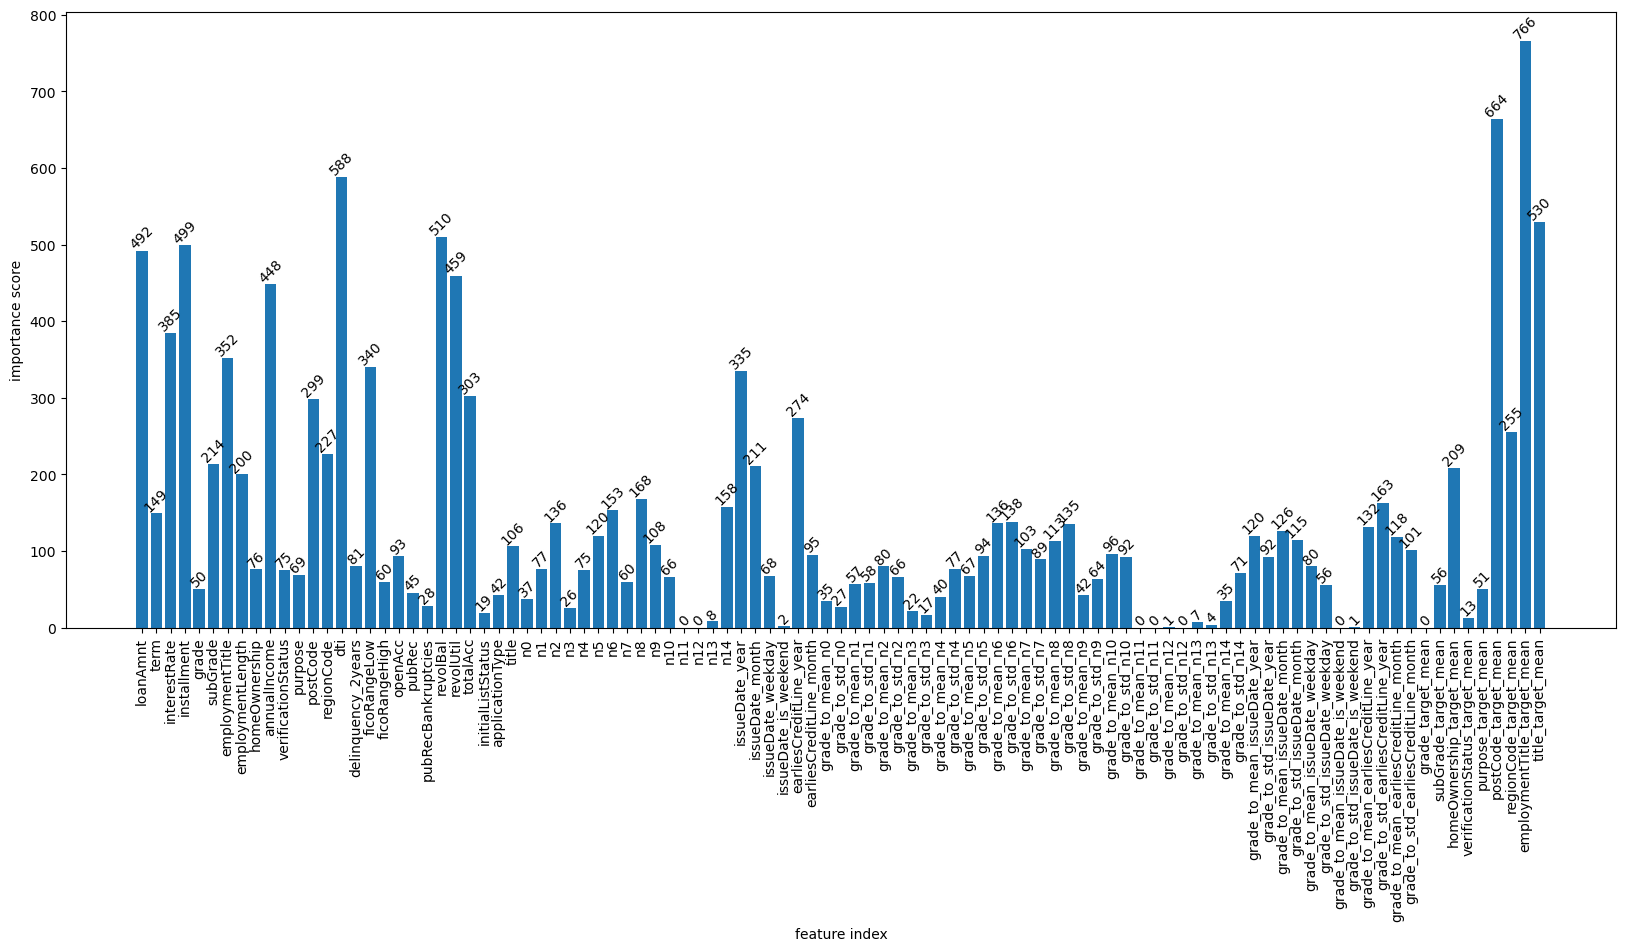

[('employmentTitle_target_mean', 766),
 ('postCode_target_mean', 664),
 ('dti', 588),
 ('title_target_mean', 530),
 ('revolBal', 510),
 ('installment', 499),
 ('loanAmnt', 492),
 ('revolUtil', 459),
 ('annualIncome', 448),
 ('interestRate', 385),
 ('employmentTitle', 352),
 ('ficoRangeLow', 340),
 ('issueDate_year', 335),
 ('totalAcc', 303),
 ('postCode', 299),
 ('earliesCreditLine_year', 274),
 ('regionCode_target_mean', 255),
 ('regionCode', 227),
 ('subGrade', 214),
 ('issueDate_month', 211),
 ('homeOwnership_target_mean', 209),
 ('employmentLength', 200),
 ('n8', 168),
 ('grade_to_std_earliesCreditLine_year', 163),
 ('n14', 158),
 ('n6', 153),
 ('term', 149),
 ('grade_to_std_n6', 138),
 ('n2', 136),
 ('grade_to_mean_n6', 136),
 ('grade_to_std_n8', 135),
 ('grade_to_mean_earliesCreditLine_year', 132),
 ('grade_to_mean_issueDate_month', 126),
 ('n5', 120),
 ('grade_to_mean_issueDate_year', 120),
 ('grade_to_mean_earliesCreditLine_month', 118),
 ('grade_to_std_issueDate_month', 115),


In [120]:
lgb_train, lgb_test, model = lgb_model(train_data, target, test_data)
# xgb_train, xgb_test = xgb_model(train_data, target, test_data)
# cat_train, cat_test = cat_model(train_data, target, test_data)

def get_feature_importance_pair(gbm_model):
    feature_name_list = gbm_model.feature_name()
    importance_list = list(gbm_model.feature_importance())
    feature_importance_pair = [(fe, round(im, 2)) for fe, im in zip(feature_name_list, importance_list)]
    # 重要性从高到低排序
    feature_importance_pair = sorted(feature_importance_pair, key=lambda x: x[1], reverse=True)
    feature_importance_top = [x[0] for x in feature_importance_pair]
    # for pair in feature_importance_pair:
    #     print('Feature: {}\t{}'.format(*pair))
    
    plt.figure(figsize=(20, 8))

    # 绘制条形图
    bars = plt.bar(range(len(feature_name_list)), importance_list)
    
    # 添加数值标签
    for bar, value in zip(bars, importance_list):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x 坐标，位于条形中心
            bar.get_height() + 3,  # y 坐标，高度稍微在条形顶部上方
            str(value),  # 标签内容
            ha='center',  # 水平居中
            rotation=45,  # 标签旋转 45 度
            fontsize=10   # 字体大小
        )

    plt.xticks(range(len(feature_name_list)), feature_name_list, rotation=90)
    plt.xlabel('feature index')
    plt.ylabel('importance score')
    plt.show()
    return feature_importance_pair, feature_importance_top

feature_importance_pair, feature_importance_top = get_feature_importance_pair(model)


In [ ]:
used_feats = []
for pair in feature_importance_pair:
        print('Feature: {}\t{}'.format(*pair))

In [121]:
sample_result = pd.read_csv("./data/sample_submit.csv")
sample_result["isDefault"] = lgb_test
sample_result.to_csv("./data/sample_result_lgb_feat_v8.csv", index=False)

## 随机搜惨

In [ ]:
# 随机搜惨
# 设置参数范围
param_dist = {
    'boosting_type': ['gbdt', 'dart'],  # 提升类型  梯度提升决策树（gbdt）和Dropouts meet Multiple Additive Regression Trees（dart）
    'objective': ['binary'],  # 目标；二分类和多分类
    'num_leaves': range(20, 150),  # 叶子节点数量
    'learning_rate': [0.01, 0.05, 0.1],  # 学习率
    'feature_fraction': [0.6, 0.8, 1.0],  # 特征采样比例
    'bagging_fraction': [0.6, 0.8, 1.0],  # 数据采样比例
    'bagging_freq': range(0, 80),  # 数据采样频率
    'verbose': [-1]  # 是否显示训练过程中的详细信息，-1表示不显示
}

# 初始化模型
model = lgb.LGBMClassifier()


# 使用随机搜索进行参数调优
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist, # 参数组合
                                   n_iter=100, 
                                   cv=5, # 5折交叉验证
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)
# 模型训练
random_search.fit(train_data, target)

# 输出最佳参数
print("Best parameters found: ", random_search.best_params_)

In [27]:
# sample_result = pd.read_csv("./data/sample_submit.csv")
# sample_result["isDefault"] = lgb_test
# sample_result.to_csv("./data/sample_result_lgb_feat_v4.csv", index=False)

## 模型融合

In [134]:
## 加权融合
lgb_result = pd.read_csv("./data/sample_result_lgb.csv")
lgb_v2_result = pd.read_csv("./data/sample_result_lgb_v2.csv")
xgb_result = pd.read_csv("./data/sample_result_xgb.csv")
cat_result = pd.read_csv("./data/sample_result_cat.csv")

lgb_result["isDefault"] = (lgb_result["isDefault"] + lgb_v2_result["isDefault"] \
                        + xgb_result["isDefault"] + cat_result["isDefault"]) / 4
lgb_result.to_csv("./data/sample_result_ensemble.csv")